In [102]:
import os

os.chdir('/home/jwdase/projects/language-detection/src')

In [103]:
import glob 

base = "/om2/user/moshepol/prosody/models/test/four_lang_prosody"

inputs = glob.glob(f'{base}/inputs*.pt')
labels = glob.glob(f'{base}/outputs*.pt')

In [104]:
print(f'Total Inputs: {len(inputs)}')
print(f'Total Outputs: {len(labels)}')

Total Inputs: 7
Total Outputs: 7


In [105]:
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

tensors = []
first = {'train' : {'en' : ''}}

for i, (inp, out) in enumerate(zip(inputs, labels)):

    if i % 5 == 0:
        print(inp.split('/')[-1])
        print(out.split('/')[-1])

    if i == 0:
        first['train']['en'] = torch.load(inp, weights_only=False)

    tensors.append(
        TensorDataset(
            torch.load(inp, weights_only=False), 
            torch.load(out, weights_only=False)
            )
        )

inputs_0.pt
outputs_0.pt
inputs_5.pt
outputs_5.pt


In [106]:
data = ConcatDataset(tensors)
loader = DataLoader(data, batch_size=256, num_workers=4, shuffle=False)

In [107]:
first['train']['en'][0].shape

torch.Size([20, 141])

In [108]:
import joblib

encoder = joblib.load(f'{base}/label_encoder.pkl')

class_to_index = {label : idx for idx, label in enumerate(encoder.classes_)}

print(class_to_index)

{np.str_('en'): 0, np.str_('de'): 1, np.str_('nl'): 2, np.str_('es'): 3, np.str_('it'): 4, np.str_('ja'): 5, np.str_('ta'): 6}


In [109]:
from language_detection.model.network import CNNRNNLanguageDetector

num_classes = len(class_to_index)

model = CNNRNNLanguageDetector(num_classes, first['train']['en'][0].shape)

model.load_state_dict(torch.load(f'{base}/best_model.pth', weights_only=True))
model.eval()

model.to('cuda')

CNNRNNLanguageDetector(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (rnn): LSTM(160, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [110]:
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, label in loader:

        inputs = inputs.to('cuda')
        label = label.to('cuda')

        inputs = inputs.unsqueeze(1)

        outputs = model(inputs)

        _, predicted = torch.max(outputs, dim=1)

        y_pred.append(predicted)
        y_true.append(label)

In [111]:
y_pred = torch.cat(y_pred).cpu()
y_true = torch.cat(y_true).cpu()

In [112]:
name = base.split('/')[-1]

In [113]:
from sklearn.metrics import accuracy_score

acc = f"Accuracy: {accuracy_score(y_true, y_pred)}"

print(acc)

with open(f'notebooks/review/{name}.txt', 'w') as f:
    f.write(acc)

Accuracy: 0.40457589285714285


In [114]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True)

print("\nClassification Report:\n", report)

df = pd.DataFrame(report)

df.to_csv(f'notebooks/review/{name}.csv')


Classification Report:
 {np.str_('en'): {'precision': 0.3853211009174312, 'recall': 0.328125, 'f1-score': 0.35443037974683544, 'support': 256.0}, np.str_('de'): {'precision': 0.3492063492063492, 'recall': 0.34375, 'f1-score': 0.3464566929133858, 'support': 256.0}, np.str_('nl'): {'precision': 0.3197278911564626, 'recall': 0.18359375, 'f1-score': 0.23325062034739455, 'support': 256.0}, np.str_('es'): {'precision': 0.32081911262798635, 'recall': 0.3671875, 'f1-score': 0.3424408014571949, 'support': 256.0}, np.str_('it'): {'precision': 0.2972972972972973, 'recall': 0.21484375, 'f1-score': 0.2494331065759637, 'support': 256.0}, np.str_('ja'): {'precision': 0.5224719101123596, 'recall': 0.7265625, 'f1-score': 0.6078431372549019, 'support': 256.0}, np.str_('ta'): {'precision': 0.501466275659824, 'recall': 0.66796875, 'f1-score': 0.5728643216080402, 'support': 256.0}, 'accuracy': 0.40457589285714285, 'macro avg': {'precision': 0.38518713385395864, 'recall': 0.40457589285714285, 'f1-score': 0

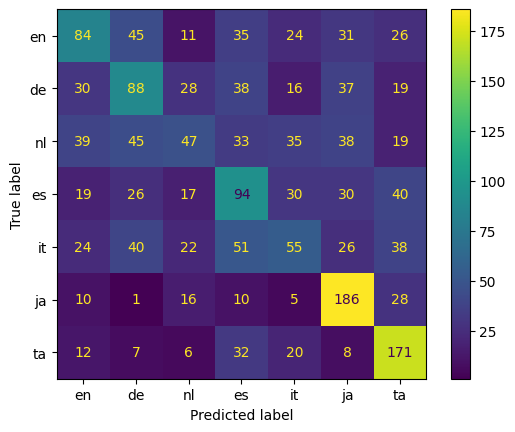

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation='horizontal')
plt.savefig(f'notebooks/review/{name}.png')